In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv


In [2]:
#imports
import pandas as pd
from collections import Counter
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
#loading the dataset
df = pd.read_csv('/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv')

x = df['statement']
y = df['status']

In [4]:
#some functions for text preprocessing
def tokenize(text):
  return text.split()

def clean_text(text):
  text = str(text)
  text = text.lower()
  return re.sub(r'[^a-zA-Z\s]','',text)

vocab = {'<UNK>':0}

def build_vocab(texts):
  counter = Counter()
  for text in texts:
    counter.update(tokenize(text))
  for word in counter:
    vocab[word] = len(vocab)

def encode_text(text):
  return [vocab.get(token,vocab['<UNK>']) for token in tokenize(text)]

In [5]:
#text formatting
x = x.apply(clean_text)
y = y.apply(clean_text)

build_vocab(x)
x = x.apply(encode_text)

le = LabelEncoder()
y = le.fit_transform(y)

In [8]:
#splitting into train and test datasets
X_train, X_test, Y_train, Y_test = train_test_split(x, y, train_size = 0.8, shuffle = True, random_state= 42)

X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)

In [9]:
#custom datasets and collate function for variable sequences
class CustomDataset(Dataset):

  def __init__(self, x, y):
    self.x = x
    self.y = y

  def __len__(self):
    return self.x.shape[0]

  def __getitem__(self,idx):
    return torch.tensor(self.x.iloc[idx], dtype=torch.long), torch.tensor(self.y[idx], dtype=torch.long)

def collatefn(batch):
  input, labels = zip(*batch)
  padded_input = pad_sequence(input,padding_side='left',padding_value=0,batch_first=True)
  return padded_input, torch.tensor(labels, dtype=torch.long)

In [10]:
#making dataloaders
train_set = CustomDataset(X_train, Y_train)
train_loader = DataLoader(train_set, batch_size = 32, shuffle = True, collate_fn = collatefn)

test_set = CustomDataset(X_test, Y_test)
test_loader = DataLoader(test_set, batch_size = 32, shuffle = True, collate_fn = collatefn)

In [19]:
#model defination
class sentiment_analyzer(nn.Module):

  def __init__(self,vocab_size,output_dim):
    super().__init__()
    self.embed = nn.Embedding(vocab_size,128,padding_idx=0)
    self.gru = nn.GRU(128, 256, batch_first = True, bidirectional=True,num_layers=3)
    self.d1 = nn.Dropout(0.4)
    self.fc1 = nn.Linear(512, 256)
    self.d2 = nn.Dropout(0.4)
    self.fc2 = nn.Linear(256, output_dim)

  def forward(self, X):

    out = self.embed(X)
    _ , h_n = self.gru(out)
    out = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)
    out = self.d1(out)
    out = F.relu(self.fc1(out))
    out = self.d2(out)
    return self.fc2(out)

#initializing the model
model = sentiment_analyzer(len(vocab), len(le.classes_))
device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

#hyperparameters
n_epochs = 50
learning_rate = 0.001
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay = 0.002)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

For Epoch 1: Loss = 1.1396630625813116
For Epoch 2: Loss = 0.9550627651552613
For Epoch 3: Loss = 0.8624432581266741
For Epoch 4: Loss = 0.8209494250981619
For Epoch 5: Loss = 0.7837342403356085
For Epoch 6: Loss = 0.7374293937609839
For Epoch 7: Loss = 0.7134444325995186
For Epoch 8: Loss = 0.6859177386001643
For Epoch 9: Loss = 0.6699611219434086
For Epoch 10: Loss = 0.6560736878763165
For Epoch 11: Loss = 0.6403175038192276
For Epoch 12: Loss = 0.6314723903215217
For Epoch 13: Loss = 0.6178758005585832
For Epoch 14: Loss = 0.6097030750587186
For Epoch 15: Loss = 0.5983189289568843
For Epoch 16: Loss = 0.590255394257019
For Epoch 17: Loss = 0.5876105497610731
For Epoch 18: Loss = 0.5759607180689655
For Epoch 19: Loss = 0.5729506238216941
For Epoch 20: Loss = 0.5639818945018455
For Epoch 21: Loss = 0.561455206382891
For Epoch 22: Loss = 0.5568045594186896
For Epoch 23: Loss = 0.5505279895356627
For Epoch 24: Loss = 0.5479099724448614
For Epoch 25: Loss = 0.5420311038661656
For Epoch 2

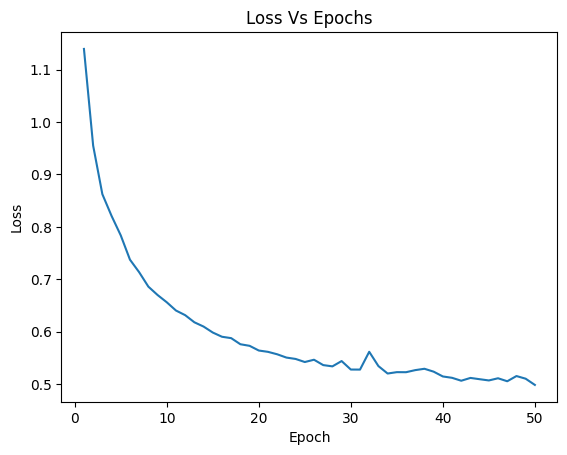

In [20]:
#training loop
graph = {}

for epoch in range(n_epochs):

  total_loss = 0

  for batch_x, batch_y in train_loader:

    batch_x,batch_y = batch_x.to(device),batch_y.to(device)

    optimizer.zero_grad()

    y_hat = model(batch_x)

    l = loss(y_hat, batch_y)

    l.backward()

    optimizer.step()

    total_loss += l.item() * len(batch_x)

  avg_loss = total_loss / len(train_loader.dataset)
  #scheduler.step(avg_loss)

  graph[epoch+1] = avg_loss

  #if (epoch+1)%10 == 0:
  print(f'For Epoch {epoch+1}: Loss = {avg_loss}')

plt.title('Loss Vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(graph.keys(),graph.values())

In [21]:
#evaluating training set accuracy
correct = 0
total = 0

model.eval()

with torch.no_grad():
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        output = model(batch_x)

        _, predicted = torch.max(output, dim=1)

        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)

accuracy = correct / total
print(f'Training Set Accuracy = {accuracy * 100:.2f}%')

Training Set Accuracy = 84.87%


In [22]:
#evaluating test accuracy
correct = 0
total = 0

model.eval()

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        output = model(batch_x)

        _, predicted = torch.max(output, dim=1)

        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)

accuracy = correct / total
print(f'Test Set Accuracy = {accuracy * 100:.2f}%')

Test Set Accuracy = 75.81%
